In [1]:
# Example of simple combined fit using iminuit v 2.
# Fit types available (choose below): LS = Least Squares, GVM = Gamma Variance Model
# G. Cowan / RHUL Physics / March 2022

import numpy as np
import scipy.stats as stats
from scipy.stats import chi2
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
print(f"iminuit version: {iminuit.__version__}")      #  should be v 2.x

iminuit version: 2.8.2


In [2]:
# Define the fit function and likelihood
class NegLogL:

    def __init__(self, x, y, s, r, fitType):
        self.setData(x, y, s, r)
        self.fitType = fitType
        
    def setData(self, x, y, s, r):
        self.data = x, y, s, r
        
    def func(self, x, par):                # fit function
        theta0 = par[0]
        theta1 = par[1]
        return theta0 + theta1*x
    
    def nll(self, par):                    # negative log-likelihood
        if self.fitType == 'LS':
            return self.nllLS(par)
        elif self.fitType == 'GVM':
            return self.nllGVM(par)
        else:
            print ("fitType ", self.fitType, " not supported")
            return -1

    def nllLS(self, par):              # ordinary least squares (r not used)
        x, y, s, r = self.data
        f = self.func(x, par)
        lnf = 0.5 * (y - f)**2 / s**2
        return np.sum(lnf)

    def nllGVM(self, par):             # Gamma Variance Model ("errors on errors")
        x, y, s, r = self.data 
        f = self.func(x, par)
        lnf = 0.5*(1. + 1./(2.*r**2))*np.log(1. + 2.*(r*(y-f))**2/s**2)
        return np.sum(lnf)

    def __call__(self, par):
        return self.nll(par)

In [3]:
# set values for two data sets and their combination
x1 = np.array([1.0, 2.0, 3.0])
y1 = np.array([2.9, 2.4, 2.3])
s1 = np.array([0.7, 0.7, 0.7])         # std. dev. of meas.
r1 = np.array([0.2, 0.2, 0.2])         # relative "error on error" (used only in GVM, not LS)

x2 = np.array([7.0, 8.0, 9.0])
y2 = np.array([5.2, 5.0, 3.9])
s2 = np.array([0.7, 0.7, 0.7])
r2 = np.array([0.2, 0.2, 0.2])

x  = np.concatenate((x1, x2), axis=0)
y  = np.concatenate((y1, y2), axis=0)
s  = np.concatenate((s1, s2), axis=0)
r  = np.concatenate((r1, r2), axis=0)

In [4]:
# Initialize Minuit and set up fit:
fitType = 'LS'                            # LS (least squares), GVM (Gamma Variance Model) 
negLogL = NegLogL(x, y, s, r, fitType)    # instantiate function to be minimized
parin     = np.array([0., 0.])            # initial values
parname = ['theta0', 'theta1']
parstep = np.array([0.1, 0.1])            # initial setp sizes
parfix  = [False, False]                  # change these to fix/free parameters
parlim  = [(None, None), (None, None)]    # set limits
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                          # errors from lnL = lnLmax - 0.5

In [5]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.
chi2min = 2.*negLogL.nll(MLE)
ndof = len(y) - m.nfit
pval = chi2.sf(chi2min, ndof)

In [6]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))
                
print()
print(r"minimized chi2 = ", chi2min)
print(r"degrees of freedom = ", ndof)
print(r"p-value from chi2min = ", pval)

par index, name, estimate, standard deviation:
   0 theta0      =  2.099425  +/-  0.541178
   1 theta1      =  0.303448  +/-  0.091915

free par indices, covariance, correlation coeff.:
0 0 0.292874 1.000000
0 1 -0.042241 -0.849208
1 0 -0.042241 -0.849208
1 1 0.008448 1.000000

minimized chi2 =  5.893150363593716
degrees of freedom =  4
p-value from chi2min =  0.20727123662782707


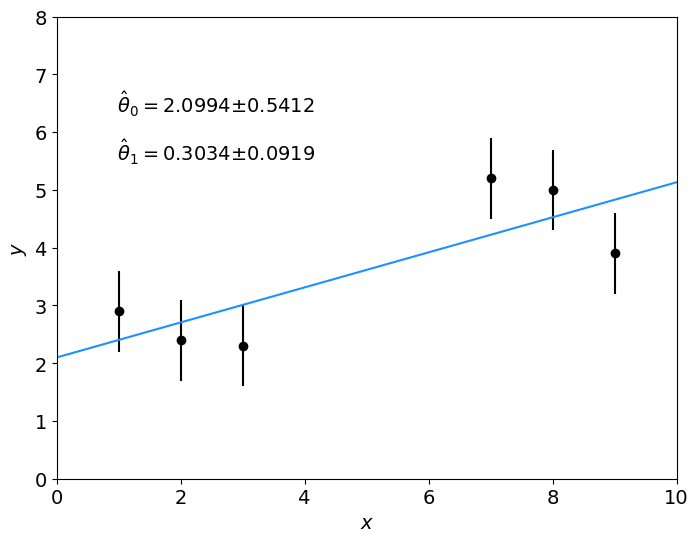

In [7]:
# Plot fitted curve with data
xMin = 0.;
xMax = 10.;
yMin = 0.
yMax = 8.
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = negLogL.func(xCurve, MLE)
plt.plot(xCurve, yCurve, color='dodgerblue')
plt.errorbar(x, y, yerr=s, xerr=0, color='black', fmt='o', label='data')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.figtext(0.2, 0.72, r'$\hat{\theta}_0 = $' + f'{MLE[0]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[0]:.4f}')
plt.figtext(0.2, 0.64, r'$\hat{\theta}_1 = $' + f'{MLE[1]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[1]:.4f}')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()

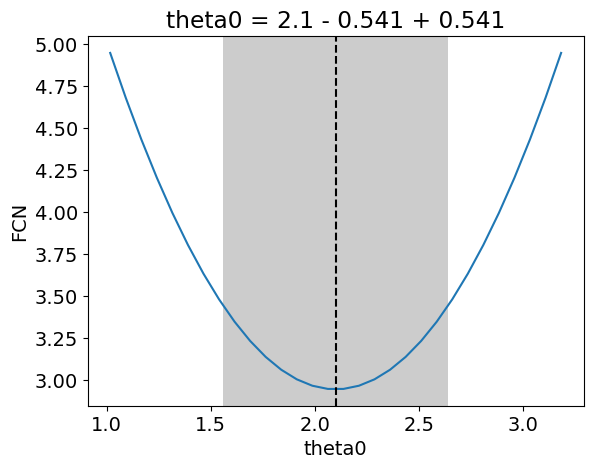

In [8]:
# Make scan of lnL (for theta0, if free)
if not(m.fixed['theta0']):
    plt.figure()
    m.draw_mnprofile('theta0')
    plt.show()

CL =  0.3934693402873665


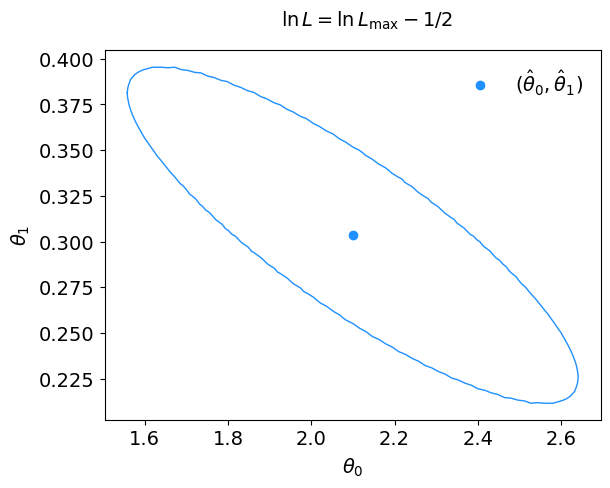

In [9]:
# Make a contour plot of lnL = lnLmax - 1/2 (here for theta0 and theta1).
# The tangents to the contour give the standard deviations of the MLEs.
CL = stats.chi2.cdf(1., m.nfit)       #  Q_alpha = 1, number of fitted param = m.nfit
print('CL = ', CL)
if not(m.fixed['theta0'] | m.fixed['theta1']):
    fig, ax = plt.subplots(1,1)
    con = m.mncontour('theta0', 'theta1', cl=CL, size=200)
    con = np.vstack([con, con[0]])         # close contour
    plt.plot(MLE[0], MLE[1], marker='o', linestyle='None', color='dodgerblue', 
             label=r'$(\hat{\theta}_0, \hat{\theta}_1)$')
    plt.plot(con[:,0], con[:,1], color='dodgerblue', linewidth=1)
    plt.xlabel(r'$\theta_0$', labelpad=5)
    plt.ylabel(r'$\theta_1$', labelpad=5)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.4, 0.93, r'$\ln L = \ln L_{\rm max} - 1/2$')
    plt.show()    

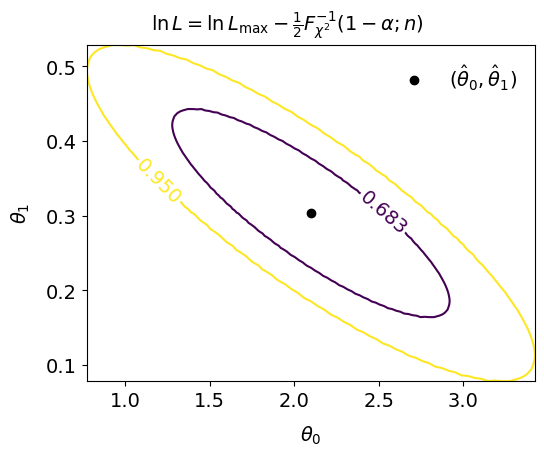

In [10]:
# Confidence region from lnL = lnLmax - Q/2 (here for theta0 and theta1)
# where Q is the chi2 quantile of CL = 1-alpha = 0.683 and 0.95 for 2 dof.
if not(m.fixed['theta0'] | m.fixed['theta1']):
    fig, ax = plt.subplots(1,1)
    m.draw_mncontour('theta0', 'theta1', cl=[0.683, 0.95], size=200);
    plt.plot(MLE[0], MLE[1], marker='o', linestyle='None', color='black', 
             label=r'$(\hat{\theta}_0, \hat{\theta}_1)$')
    plt.xlabel(r'$\theta_0$', labelpad=10)
    plt.ylabel(r'$\theta_1$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.3, 0.93, 
                r'$\ln L = \ln L_{\rm max} - \frac{1}{2} F^{-1}_{\chi^2}(1-\alpha;n)$')
    plt.show()